In [1]:
import numpy as np
import torch
import torchvision.datasets as dsets

In [2]:
import json

imnet = json.load(open("imagenet_class_index.json"))
class_idx = imnet
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [3]:
def image_folder_custom_label(root, transform, idx2label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root=root, transform=transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root=root, transform=transform, 
                                 target_transform=lambda x : idx2label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [4]:
def mask_generation(mask_type='rectangle', patch=None, image_size=(3, 224, 224)):
    applied_patch = np.zeros(image_size)
    if mask_type == 'rectangle':
        # patch rotation
        rotation_angle = np.random.choice(4)
        for i in range(patch.shape[0]):
            patch[i] = np.rot90(patch[i], rotation_angle)  # The actual rotation angle is rotation_angle * 90
        # patch location
        x_location, y_location = np.random.randint(low=0, high=image_size[1]-patch.shape[1]), np.random.randint(low=0, high=image_size[2]-patch.shape[2])
        for i in range(patch.shape[0]):
            applied_patch[:, x_location:x_location + patch.shape[1], y_location:y_location + patch.shape[2]] = patch
    mask = applied_patch.copy()
    mask[mask != 0] = 1.0
    return applied_patch, mask, x_location, y_location

def test_patch(patch_type, target, patch, test_loader, model):
    model.eval()
    test_total, test_actual_total, test_success = 0, 0, 0
    for (image, label) in test_loader:
        test_total += label.shape[0]
        assert image.shape[0] == 1, 'Only one picture should be loaded each time.'
        image = image.cuda()
        label = label.cuda()
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        print("Original class: ", predicted)
        
        applied_patch, mask, x_location, y_location = mask_generation(patch_type, patch, image_size=(3, 224, 224))
        applied_patch = torch.from_numpy(applied_patch)
        mask = torch.from_numpy(mask)
        perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
        perturbated_image = perturbated_image.cuda()
        output = model(perturbated_image)
        _, predicted = torch.max(output.data, 1)
        print("New class: ", predicted)
        
        return perturbated_image[0]
        
#         if predicted[0] != label and predicted[0].data.cpu().numpy() != target:
#             test_actual_total += 1
#             applied_patch, mask, x_location, y_location = mask_generation(patch_type, patch, image_size=(3, 224, 224))
#             applied_patch = torch.from_numpy(applied_patch)
#             mask = torch.from_numpy(mask)
#             perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
#             perturbated_image = perturbated_image.cuda()
#             output = model(perturbated_image)
#             _, predicted = torch.max(output.data, 1)
#             if predicted[0].data.cpu().numpy() == target:
#                 test_success += 1
#     return test_success / test_actual_total

In [6]:
import torchvision
import torchvision.transforms as transforms

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [7]:
imagnet_data = image_folder_custom_label(root='./images', transform=test_transforms, idx2label=idx2label)
data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)

In [12]:
from torchvision import models

resnet = models.resnet50(pretrained=True).cuda()
resnet = resnet.eval()

In [15]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [52]:
from PIL import Image 
image_patch = Image.open('./training_pictures/0 patch.png')
# patch = np.clip(np.asarray(image_patch)[:,:,:3] * std + mean, 0, 1) 
patch = np.asarray(image_patch)[:,:,:3] 
patch = np.transpose(patch, (2, 0, 1)).copy()

img = test_patch('rectangle', 123, patch, data_loader, resnet)

Original class:  tensor([404], device='cuda:0')
New class:  tensor([920], device='cuda:0')


In [48]:
import matplotlib.pyplot as plt

# mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
full_img = np.clip(np.transpose(img.cpu().numpy(), (1, 2, 0)) * std + mean, 0, 1) 
# full_img = np.transpose(img.cpu().numpy(), (1, 2, 0)) 
plt.imsave("test.png", full_img)

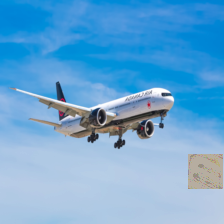

In [49]:
pil_img = Image.fromarray((full_img * 255).astype(dtype='uint8'), 'RGB')
pil_img

In [42]:
idx2label[920]

'traffic_light'

In [50]:
inception = models.inception_v3(pretrained=True).cuda()
inception = inception.eval()

In [51]:
r = test_patch('rectangle', 123, patch, data_loader, inception)

Original class:  tensor([812], device='cuda:0')
New class:  tensor([404], device='cuda:0')


# Load model and image

In [53]:
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=

env: AWS_ACCESS_KEY_ID=
env: AWS_SECRET_ACCESS_KEY=


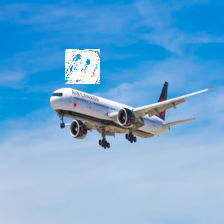

In [32]:
pil_img

In [45]:
import boto3
import io

rekognition_client = boto3.client('rekognition')
def detect_labels(image, max_labels):
    """
    Detects labels in the image. Labels are objects and people.

    :param max_labels: The maximum number of labels to return.
    :return: The list of labels detected in the image.
    """
    try:
        in_mem_file = io.BytesIO()
        image.save(in_mem_file, format="jpeg")
        image_json = {'Bytes': in_mem_file.getvalue()}
        response = rekognition_client.detect_labels(
            Image=image_json, MaxLabels=max_labels)
        labels = response['Labels']
    except ClientError:
        logger.info("Couldn't detect labels in %s.", self.image_name)
        raise
    else:
        return labels

detect_labels(pil_img, 6)

[{'Name': 'Vehicle',
  'Confidence': 92.6502685546875,
  'Instances': [],
  'Parents': [{'Name': 'Transportation'}]},
 {'Name': 'Transportation',
  'Confidence': 92.6502685546875,
  'Instances': [],
  'Parents': []},
 {'Name': 'Aircraft',
  'Confidence': 92.32183837890625,
  'Instances': [],
  'Parents': [{'Name': 'Vehicle'}, {'Name': 'Transportation'}]},
 {'Name': 'Flight',
  'Confidence': 88.7389907836914,
  'Instances': [],
  'Parents': [{'Name': 'Aircraft'},
   {'Name': 'Vehicle'},
   {'Name': 'Transportation'}]},
 {'Name': 'Airplane',
  'Confidence': 87.20586395263672,
  'Instances': [{'BoundingBox': {'Width': 0.7436196208000183,
     'Height': 0.31705355644226074,
     'Left': 0.07327686250209808,
     'Top': 0.3389257490634918},
    'Confidence': 87.20586395263672}],
  'Parents': [{'Name': 'Aircraft'},
   {'Name': 'Vehicle'},
   {'Name': 'Transportation'}]},
 {'Name': 'Takeoff',
  'Confidence': 81.30126190185547,
  'Instances': [],
  'Parents': [{'Name': 'Aircraft'},
   {'Name':